In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Define Data

In [3]:
df = pd.read_csv('../project_2/catdogdata.txt', delimiter = ' ')



df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [4]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

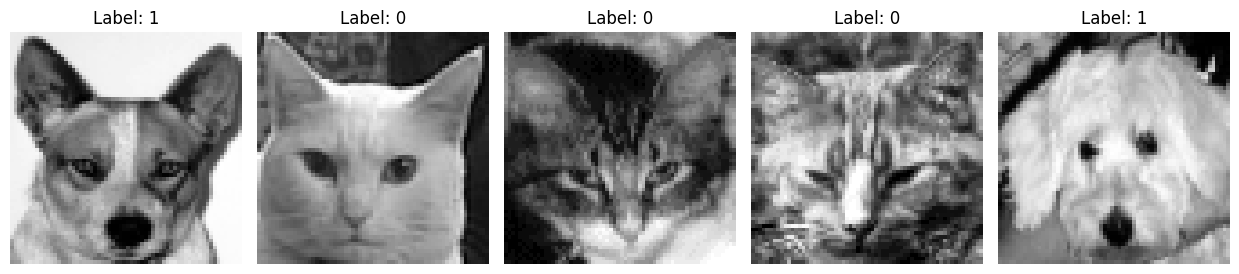

In [5]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

In [8]:
df_mnist = pd.read_csv('../project_2/Numbers.txt', delimiter=' ')

# first column is the label
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values


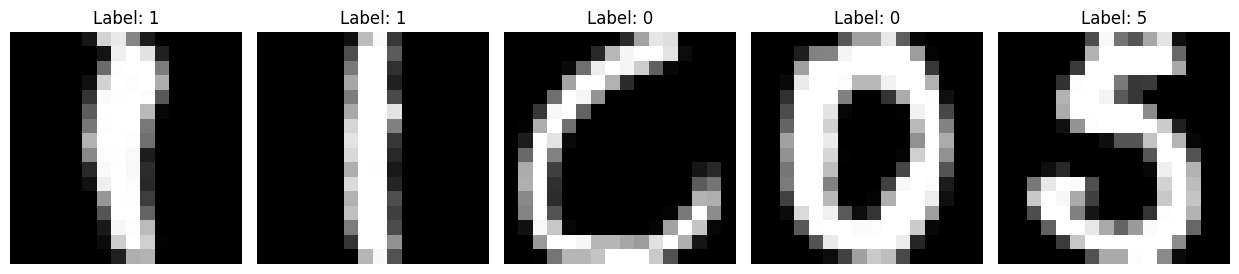

In [9]:
# create a function to plot examples
def plot_examples_mnist(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((16, 16))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# plot example images
plot_examples_mnist(df_mnist, n=5)

# Make a low dimensional representation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


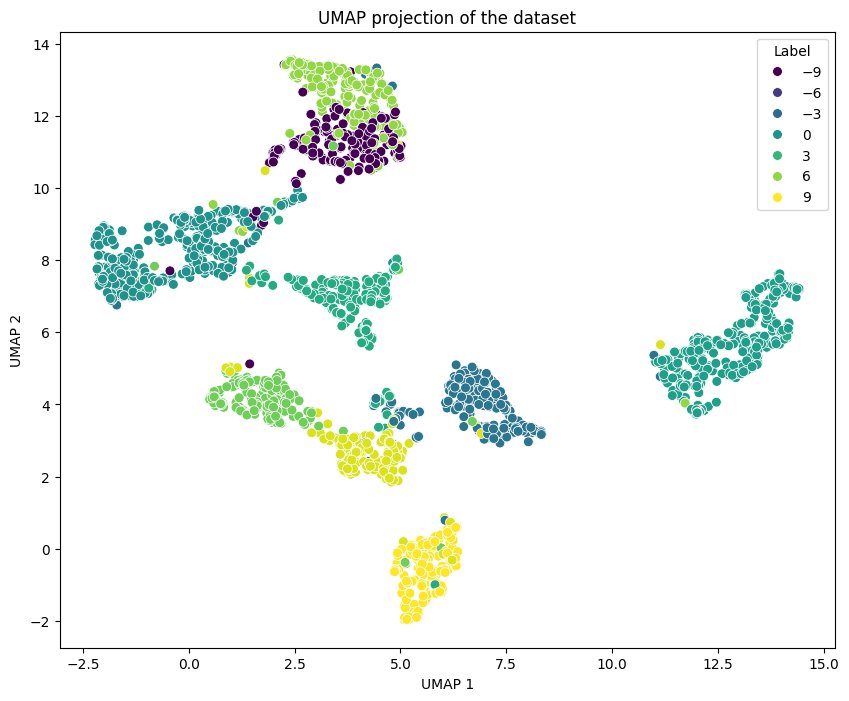

In [42]:
# Use UMAP to create a low-dimensional representation of the data
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and the last column is the label
X = df_mnist.iloc[:, :-1].values
y = df_mnist.iloc[:, -1].values
# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()

100%|██████████| 19/19 [00:07<00:00,  2.51it/s]


Best parameters: eps=0.5, min_samples=7


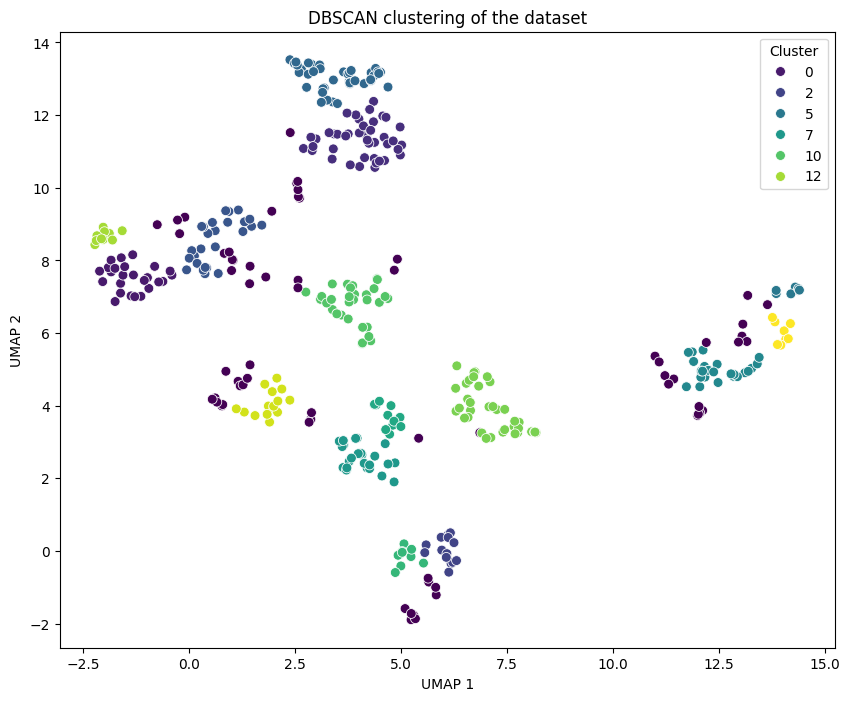

Silhouette Score: 0.34328749775886536


In [ ]:
# use the filtered dataset for DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# CV for DBSCAN for eps and umap
def dbscan_cv(X, y, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_model = None

    for eps in tqdm(eps_values):
        for min_samples in min_samples_values:
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Calculate silhouette score
            if len(set(labels)) > 1:  # Ensure more than one cluster
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_model = dbscan

    return best_params, best_model


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=42)


# Define the range of parameters to test
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = np.arange(2, 10, 1)
# Perform cross-validation
best_params, best_model = dbscan_cv(X_train, y, eps_values, min_samples_values)
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")

# Apply the best DBSCAN model to the data
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
labels = dbscan.fit_predict(X_test)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=labels, palette='viridis', s=50)
plt.title('DBSCAN clustering of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.show()

# print silhouette score
if len(set(labels)) > 1:  # Ensure more than one cluster
    score = silhouette_score(X_test, labels)
    print(f"Silhouette Score: {score}")
    


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


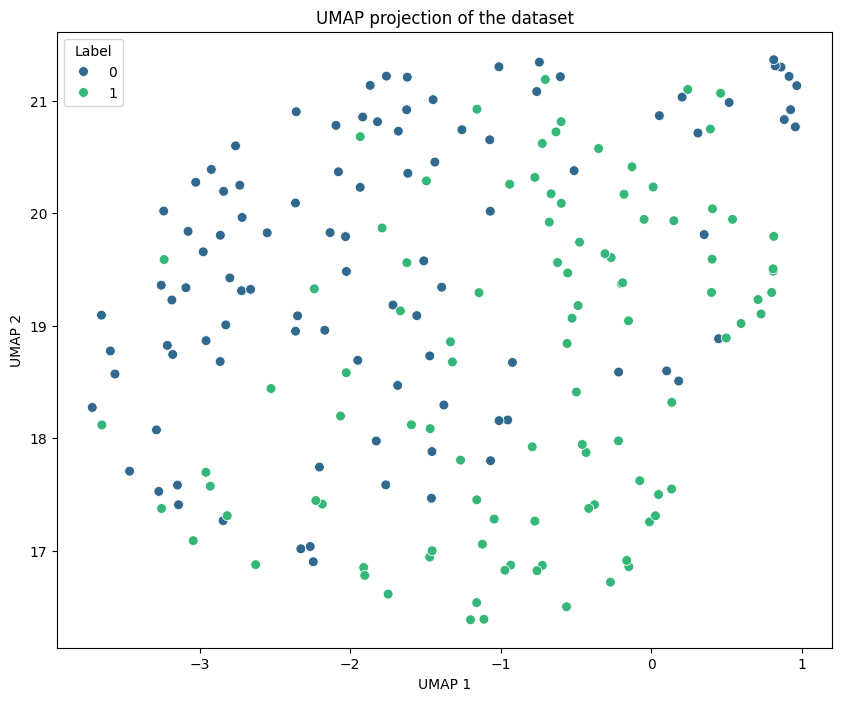

In [40]:
# Now for the cat-dog dataset
# Use UMAP to create a low-dimensional representation of the data

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)
# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()


100%|██████████| 8/8 [00:00<00:00, 1153.87it/s]


Best parameters: eps=0.30000000000000004, min_samples=2


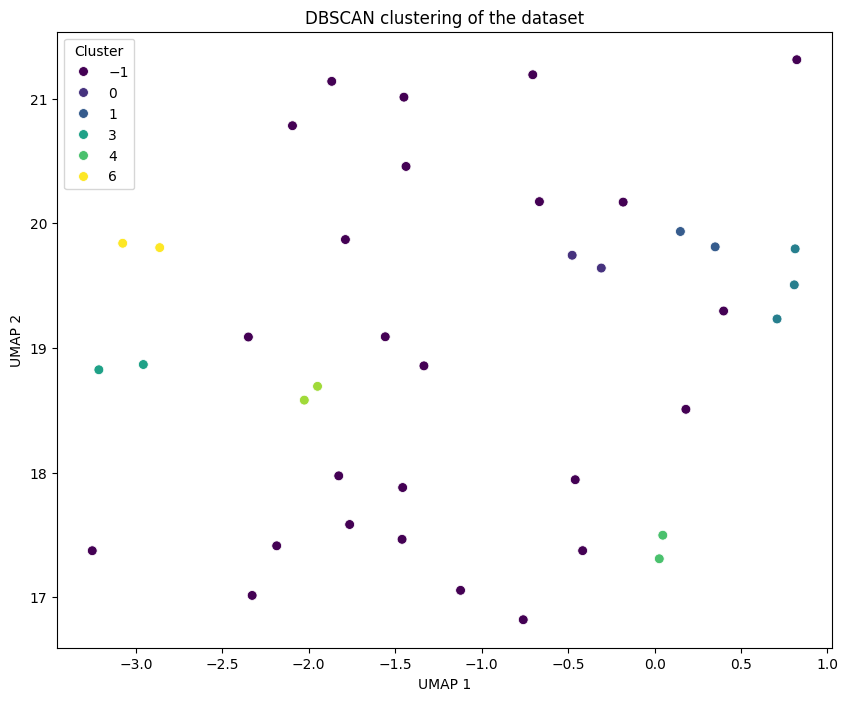

Silhouette Score: -0.07396256923675537


In [ ]:
# use the filtered dataset for UMAP
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
# CV for DBSCAN for eps

def dbscan_cv(X, y, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_model = None

    for eps in tqdm(eps_values):
        for min_samples in min_samples_values:
            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Calculate silhouette score
            if len(set(labels)) > 1:  # Ensure more than one cluster
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_model = dbscan

    return best_params, best_model

# Define the range of parameters to test
eps_values = np.arange(0.1, 2.0, 0.1)
min_samples_values = np.arange(2, 10, 1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=42)

# Perform cross-validation
best_params, best_model = dbscan_cv(X_train, y, eps_values, min_samples_values)
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")

# Apply the best DBSCAN model to the data
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
labels = dbscan.fit_predict(X_test)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=labels, palette='viridis', s=50)
plt.title('DBSCAN clustering of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster')
plt.show()

# print silhouette score
if len(set(labels)) > 1:  # Ensure more than one cluster
    score = silhouette_score(X_test, labels)
    print(f"Silhouette Score: {score}")
    